In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import lightgbm as lgb

In [2]:
# Display Options of DataFrame
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Loading Swap Rate Dataset
data = pd.read_csv("../cleanedData/merged.csv")

In [4]:
data['CMS Tenor'] = data['CMS Tenor'].str.removesuffix('y')
data['CMS Tenor'] = data['CMS Tenor'].astype(int)

In [5]:
# Find lag 1 by shifting the amount of data in one date
delay = len(data.loc[data['Value Date'] == "2022-09-02"])

# Realized Swap Rate Prev
data['Swap Rate Lag 1 (Real)'] = data['Swap Rate'].shift(delay)

In [6]:
data

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real)
0,2022-09-02,dummyTrade1,USD,-100,-0.01000,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,NaN
1,2022-09-02,dummyTrade1,USD,-50,-0.00500,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,NaN
2,2022-09-02,dummyTrade1,USD,-25,-0.00250,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,NaN
3,2022-09-02,dummyTrade1,USD,-10,-0.00100,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,NaN
4,2022-09-02,dummyTrade1,USD,-5,-0.00050,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,dummyTrade9,USD,10,0.00100,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.03069
3919100,2024-01-12,dummyTrade9,USD,25,0.00250,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.03069
3919101,2024-01-12,dummyTrade9,USD,50,0.00500,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,0.03069
3919102,2024-01-12,dummyTrade9,USD,75,0.00750,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,0.03069


In [7]:
zero_subset = data['Zero Rate Shock'] == 0
shock_subset = -zero_subset
zero = data[zero_subset].reset_index(drop = True)
shock = data[shock_subset].reset_index(drop = True)

In [8]:
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real)
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052


In [9]:
delay = len(zero.loc[zero['Value Date'] == "2022-09-02"])
zero['Vols Prev'] = zero['Vols'].shift(delay)
zero['Vols Change'] = zero['Vols'] - zero['Vols Prev']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264


In [10]:
# Find Risk of RAN notes contributed by swaption IV changes

# change in TV caused by vega (t=0) = previous vega (t-1)* vol change
zero['Vega Lag 1']  = zero['Vega'].shift(delay)
zero['Vega Risk Exposure'] = zero['Vols Change'] * zero['Vega Lag 1']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.15633,-0.00041
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.20701,-0.00055
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,5.04961,0.01331
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,4.26339,0.01124


In [11]:
zero['Vega Risk Exposure'].describe()

count   325620.00000
mean         0.02697
std         22.07968
min      -3300.85208
25%         -0.00761
50%          0.00000
75%          0.00829
max       5232.58544
Name: Vega Risk Exposure, dtype: float64

In [12]:
zero['Swap Rate Change'] = zero['Swap Rate'] - zero['Swap Rate Lag 1 (Real)']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069


In [13]:
zero['TV Lag 1'] = zero['TV'].shift(delay)
zero['TV Change'] = zero['TV'] - zero['TV Lag 1'] 
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029


In [14]:
#zero['TV Change'].describe()

In [15]:
#zero[zero['TV Change'] == zero['TV Change'].max()]
#zero[(zero['Value Date'] == '2023-04-24') & (zero['Trade Name'] == "dummyTrade12")]

In [16]:
#Zero Shock data subset preprocessing Completed  

#Shock data subset Follows->>>

### MUST READ: For Shock data subset, use in place comparison with t=0 and baseline = zero rate, don't use other method like time comparison!!



In [17]:
# Use Joins (pd.merge) to map zero rate data for each of them
select_bucket = ['Value Date', 'Trade Name', 'TV', 'Expiry Bucket', 'Tenor Bucket', 'Vega']
zero_tojoin = zero[select_bucket]

# Lag 1 Means Zero Shock in shock subset
zero_tojoin = zero_tojoin.rename(columns={'TV': 'TV Lag 1', 'Vega':'Vega Lag 1'}).reset_index(drop = True)

join_bucket = ['Value Date', 'Trade Name', 'Expiry Bucket', 'Tenor Bucket']
shock = shock.merge(zero_tojoin, on = join_bucket)
shock

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),TV Lag 1,Vega Lag 1
0,2022-09-02,dummyTrade1,USD,-100,-0.01000,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,NaN,-215402.65615,5.01627
1,2022-09-02,dummyTrade1,USD,-50,-0.00500,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,NaN,-215402.65615,5.01627
2,2022-09-02,dummyTrade1,USD,-25,-0.00250,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,NaN,-215402.65615,5.01627
3,2022-09-02,dummyTrade1,USD,-10,-0.00100,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,NaN,-215402.65615,5.01627
4,2022-09-02,dummyTrade1,USD,-5,-0.00050,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,NaN,-215402.65615,5.01627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592507,2024-01-12,dummyTrade9,USD,10,0.00100,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.03069,-563257.81996,5.09762
3592508,2024-01-12,dummyTrade9,USD,25,0.00250,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.03069,-563257.81996,5.09762
3592509,2024-01-12,dummyTrade9,USD,50,0.00500,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,0.03069,-563257.81996,5.09762
3592510,2024-01-12,dummyTrade9,USD,75,0.00750,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,0.03069,-563257.81996,5.09762


In [18]:
# Finding TV change
shock['TV Change'] = shock['TV'] - shock['TV Lag 1']

# Vols here is 0 shock vols, rename to better represent
# Swap Rate here is swap rate at 0 shock
shock = shock.rename(columns={"Vols":"Vols Lag 1", "Swap Rate": "Swap Rate Lag 1"})

# Rename current swap rate to current shocked swap rate
shock = shock.rename(columns={"Swap Rate (Shocked)": "Swap Rate"})

In [19]:
# Renaming and dropping unused column, unifying naming of shock and zero data subset
shock['Swap Rate Change'] = shock['Zero Rate Shock (DEC)']
shock = shock.drop(columns= ['Zero Rate Shock (DEC)', 'Swap Rate Lag 1 (Real)'])

In [20]:
shock

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate Lag 1,Swap Rate,lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols Lag 1,TV Lag 1,Vega Lag 1,TV Change,Swap Rate Change
0,2022-09-02,dummyTrade1,USD,-100,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,-215402.65615,5.01627,-12504.44262,-0.01000
1,2022-09-02,dummyTrade1,USD,-50,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,-215402.65615,5.01627,-6805.74481,-0.00500
2,2022-09-02,dummyTrade1,USD,-25,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,-215402.65615,5.01627,-3558.27184,-0.00250
3,2022-09-02,dummyTrade1,USD,-10,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,-215402.65615,5.01627,-1469.77395,-0.00100
4,2022-09-02,dummyTrade1,USD,-5,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,-215402.65615,5.01627,-743.65418,-0.00050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592507,2024-01-12,dummyTrade9,USD,10,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,-563257.81996,5.09762,15405.76403,0.00100
3592508,2024-01-12,dummyTrade9,USD,25,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,-563257.81996,5.09762,42029.23234,0.00250
3592509,2024-01-12,dummyTrade9,USD,50,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,-563257.81996,5.09762,98351.83787,0.00500
3592510,2024-01-12,dummyTrade9,USD,75,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,-563257.81996,5.09762,171942.77803,0.00750


In [21]:
# TODO: Vols (SABR, pending)		Vols Change(SABR, pending)	 
# Vega Risk Exposure(SABR, pending)	#Vega Risk Exposure Total

In [22]:
shock['TV Change'].describe() 

count   3592512.00000
mean      14591.99638
std       57968.50351
min     -208656.31626
25%       -9385.94673
50%        1840.45578
75%       24708.37428
max      415346.87583
Name: TV Change, dtype: float64

In [23]:
# ---------
# Actual IR Model

In [24]:
#group by sum
totalVegaRisk = zero.groupby(['Value Date', 'Trade Name'])['Vega Risk Exposure'].sum()
# Numpy Array of Total risk shown
totalVegaRisk = pd.DataFrame(totalVegaRisk)
totalVegaRisk = totalVegaRisk.rename(columns = {'Vega Risk Exposure': 'Vega Risk Exposure (Total)'})

# Convert to a DF to merge back to orginal dataframe
zero = zero.merge(totalVegaRisk, on = ['Value Date', 'Trade Name'], how = "left")

In [25]:
zero['Vega Risk Exposure (Total)'].drop_duplicates().describe()

count    4021.00000
mean        2.18373
std       148.19848
min     -1787.41276
25%        -3.39219
50%         0.00506
75%         3.21881
max      8577.49063
Name: Vega Risk Exposure (Total), dtype: float64

In [26]:
zero['TV Change (Net of Vega)'] = zero['TV Change'] - zero['Vega Risk Exposure (Total)']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (Total),TV Change (Net of Vega)
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326,6.94095,272.03231
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393,6.94158,268.13234
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505,34.62008,2316.28498
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029,34.87129,2321.11900


In [27]:
zero.columns
#

Index(['Value Date', 'Trade Name', 'Trade Currency', 'Zero Rate Shock',
       'Zero Rate Shock (DEC)', 'TV', 'Expiry Bucket', 'Expiry Date',
       'Tenor Bucket', 'Vega', 'CMS Tenor', 'Swap Rate', 'Swap Rate (Shocked)',
       'lower_bound', 'upper_bound', 'bound width', 'month_pay_frequency',
       'year_maturity', 'Distance_lower (Shocked)', 'Distance_upper (Shocked)',
       'Out of Bound', 'Swap_Bound Distance', 'Vols', 'Swap Rate Lag 1 (Real)',
       'Vols Prev', 'Vols Change', 'Vega Lag 1', 'Vega Risk Exposure',
       'Swap Rate Change', 'TV Lag 1', 'TV Change',
       'Vega Risk Exposure (Total)', 'TV Change (Net of Vega)'],
      dtype='object')

In [28]:
zero = zero.dropna()

In [29]:
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (Total),TV Change (Net of Vega)
972,2022-09-06,dummyTrade1,USD,0,0.00000,-213822.82723,1.00000,2023-09-06,10.00000,2.04819,2,0.03026,0.03026,0.00420,0.03790,0.03370,6,5,0.02606,0.00764,False,0.00764,0.16844,0.02916,0.17753,-0.00908,5.01627,-0.04555,0.00111,-215402.65615,1579.82892,-0.84845,1580.67737
973,2022-09-06,dummyTrade10,USD,0,0.00000,-608794.62408,1.00000,2023-09-06,10.00000,-102.12255,5,0.02852,0.02852,0.00440,0.03970,0.03530,4,10,0.02412,0.01118,False,0.01118,0.16844,0.02725,0.17753,-0.00908,-59.82041,0.54325,0.00128,-616299.36924,7504.74516,-7.84832,7512.59348
974,2022-09-06,dummyTrade11,USD,0,0.00000,-602313.87632,1.00000,2023-09-06,10.00000,20.55242,10,0.02853,0.02853,0.00460,0.04170,0.03710,4,10,0.02393,0.01317,False,0.01317,0.16844,0.02738,0.17753,-0.00908,7.76260,-0.07049,0.00115,-608678.01098,6364.13466,-11.67438,6375.80904
975,2022-09-06,dummyTrade12,USD,0,0.00000,-603011.20245,1.00000,2023-09-06,10.00000,13.52246,10,0.02853,0.02853,0.00460,0.04170,0.03710,3,10,0.02393,0.01317,False,0.01317,0.16844,0.02738,0.17753,-0.00908,25.32978,-0.23003,0.00115,-609360.66241,6349.45996,-11.65973,6361.11969
976,2022-09-06,dummyTrade2,USD,0,0.00000,-214277.74913,1.00000,2023-09-06,10.00000,0.16347,2,0.03026,0.03026,0.00420,0.03790,0.03370,4,5,0.02606,0.00764,False,0.00764,0.16844,0.02916,0.17753,-0.00908,5.40938,-0.04912,0.00111,-215836.78721,1559.03807,-0.84982,1559.88790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326,6.94095,272.03231
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393,6.94158,268.13234
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505,34.62008,2316.28498
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029,34.87129,2321.11900


In [30]:
zero = zero.drop_duplicates(["Value Date", "Trade Name"]).reset_index(drop = True)
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (Total),TV Change (Net of Vega)
0,2022-09-06,dummyTrade1,USD,0,0.00000,-213822.82723,1.00000,2023-09-06,10.00000,2.04819,2,0.03026,0.03026,0.00420,0.03790,0.03370,6,5,0.02606,0.00764,False,0.00764,0.16844,0.02916,0.17753,-0.00908,5.01627,-0.04555,0.00111,-215402.65615,1579.82892,-0.84845,1580.67737
1,2022-09-06,dummyTrade10,USD,0,0.00000,-608794.62408,1.00000,2023-09-06,10.00000,-102.12255,5,0.02852,0.02852,0.00440,0.03970,0.03530,4,10,0.02412,0.01118,False,0.01118,0.16844,0.02725,0.17753,-0.00908,-59.82041,0.54325,0.00128,-616299.36924,7504.74516,-7.84832,7512.59348
2,2022-09-06,dummyTrade11,USD,0,0.00000,-602313.87632,1.00000,2023-09-06,10.00000,20.55242,10,0.02853,0.02853,0.00460,0.04170,0.03710,4,10,0.02393,0.01317,False,0.01317,0.16844,0.02738,0.17753,-0.00908,7.76260,-0.07049,0.00115,-608678.01098,6364.13466,-11.67438,6375.80904
3,2022-09-06,dummyTrade12,USD,0,0.00000,-603011.20245,1.00000,2023-09-06,10.00000,13.52246,10,0.02853,0.02853,0.00460,0.04170,0.03710,3,10,0.02393,0.01317,False,0.01317,0.16844,0.02738,0.17753,-0.00908,25.32978,-0.23003,0.00115,-609360.66241,6349.45996,-11.65973,6361.11969
4,2022-09-06,dummyTrade2,USD,0,0.00000,-214277.74913,1.00000,2023-09-06,10.00000,0.16347,2,0.03026,0.03026,0.00420,0.03790,0.03370,4,5,0.02606,0.00764,False,0.00764,0.16844,0.02916,0.17753,-0.00908,5.40938,-0.04912,0.00111,-215836.78721,1559.03807,-0.84982,1559.88790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,1.00000,2025-01-13,10.00000,0.78280,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.92804,0.03188,0.92354,0.00450,0.75365,0.00339,-0.00016,-201031.68108,278.97326,6.94095,272.03231
4016,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,1.00000,2025-01-13,10.00000,-4.09032,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.92804,0.03188,0.92354,0.00450,-4.36658,-0.01967,-0.00016,-201241.28870,275.07393,6.94158,268.13234
4017,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,1.00000,2025-01-13,10.00000,-24.00955,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.92804,0.03052,0.92354,0.00450,41.87847,0.18864,-0.00069,-509747.56833,2350.90505,34.62008,2316.28498
4018,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,1.00000,2025-01-13,10.00000,41.98539,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.92804,0.03052,0.92354,0.00450,8.07293,0.03637,-0.00069,-510774.02962,2355.99029,34.87129,2321.11900


In [31]:
target = "TV Change (Net of Vega)"
product_features = ['CMS Tenor', 
       'lower_bound', 'upper_bound', 'bound width', 'month_pay_frequency',
       'year_maturity', 'Distance_lower (Shocked)', 'Distance_upper (Shocked)',
       'Out of Bound', 'Swap_Bound Distance']
swaption_features = ['Expiry Bucket', 'Expiry Date', 'Tenor Bucket', 'Vega', 'Vols Prev', 'Vols Change', 'Vega Lag 1']
swap_features = ['Swap Rate', 'Swap Rate (Shocked)', 'Swap Rate Lag 1 (Real)', 'Swap Rate Change']
features = ['Swap Rate Change', # dominant features -> Swap Rate
            'CMS Tenor', 'month_pay_frequency', 'year_maturity', 'Out of Bound', 'Swap_Bound Distance'] # Product features to include


In [32]:
from sklearn.preprocessing import PolynomialFeatures


In [33]:
data = zero
y = data[target]
X = data[features]

#poly = PolynomialFeatures(3)
#X = poly.fit_transform(X)

In [34]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category' or col_type == 'bool':
        X[c] = X[c].astype('category')

C:\Users\chanj\AppData\Local\Temp\ipykernel_21300\2572825890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


In [35]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42
# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 


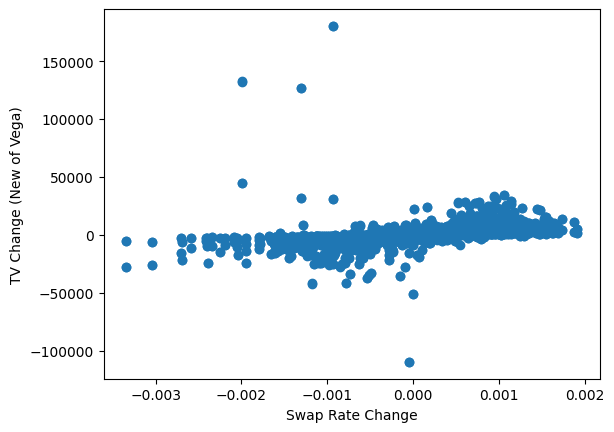

In [36]:
plt.scatter(data["Swap Rate Change"], data["TV Change (Net of Vega)"])
plt.xlabel("Swap Rate Change")
plt.ylabel("TV Change (New of Vega)")
# show the legend
plt.show()

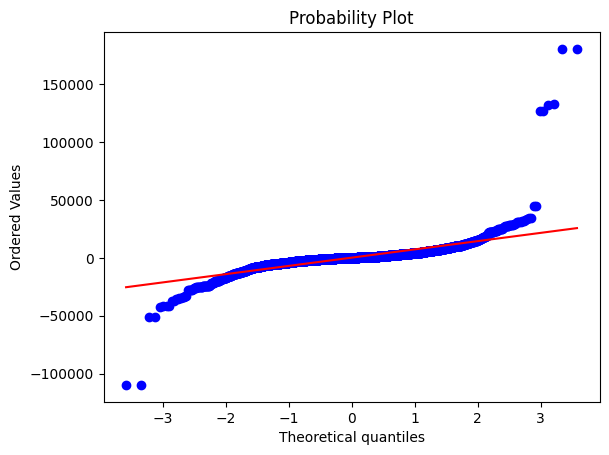

In [37]:
import scipy.stats as stats
import pylab
stats.probplot( (data["TV Change (Net of Vega)"]), dist="norm", plot=pylab)
pylab.show()

In [38]:
# initialize Gradient Boosting model

params = {"n_estimators": 200, 
          "metric": "huber",
          "learning_rate": 0.07,           
          "num_leaves": 20,                
          "max_depth": 12,                          
          "early_stopping_round": 7,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 0.9,                         
          "min_split_gain": 0.05,                          
          "max_bin": 1000,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": -1, 
          "force_col_wise": True,
          }
model = lgb.LGBMRegressor(**params)
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Calculate R^2 and R^2 adj to evaluate model adequacy
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

R^2 = 0.5321047419132288
Adjusted R^2 = 0.5249974721701385


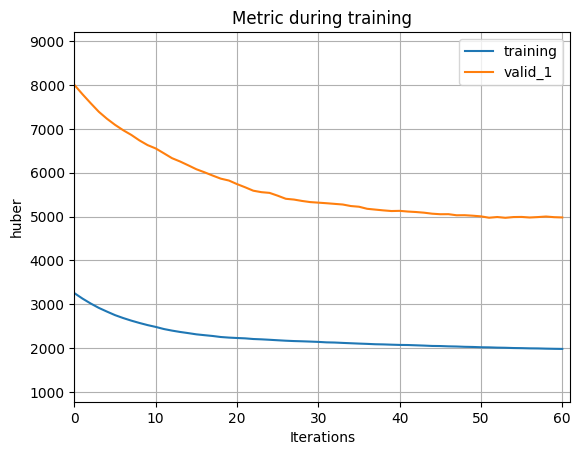

In [39]:
# retrieve performance metrics
lgb.plot_metric(model)
plt.show()

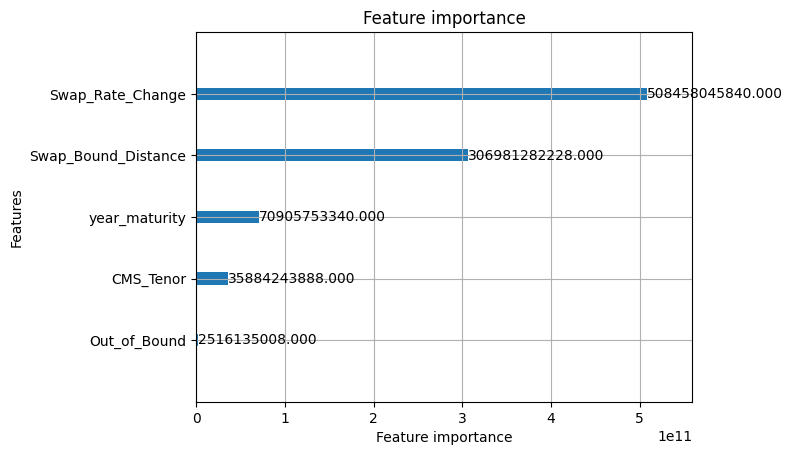

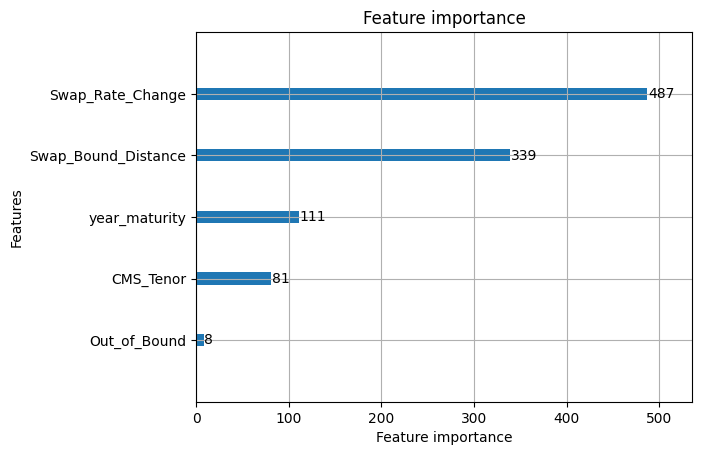

In [40]:
lgb.plot_importance(model, importance_type='gain')
lgb.plot_importance(model, importance_type='split')
plt.show()

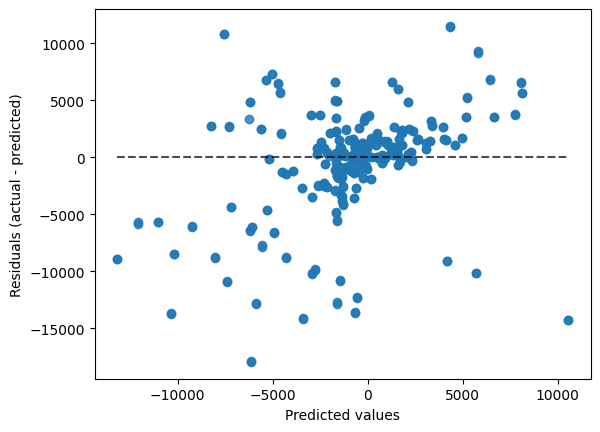

In [41]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

Text(0, 0.5, 'predicted')

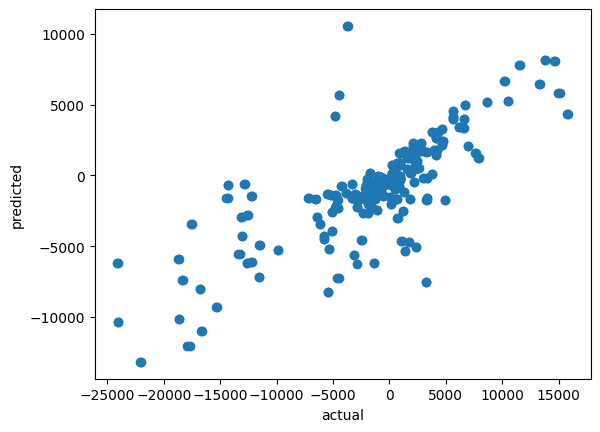

In [42]:
plt.scatter(y_test, y_pred)
plt.xlabel("actual")
plt.ylabel("predicted")

In [43]:
def test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
    print("R^2:", score)
    print("Adjusted R^2:", score)
    y_pred = model.predict(X_test)
    display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
    display.plot()
    plt.show()
    return score

In [44]:
# Model Testing

from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge, HuberRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import  RandomForestRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

R^2: 0.5229342722938729
Adjusted R^2: 0.5229342722938729


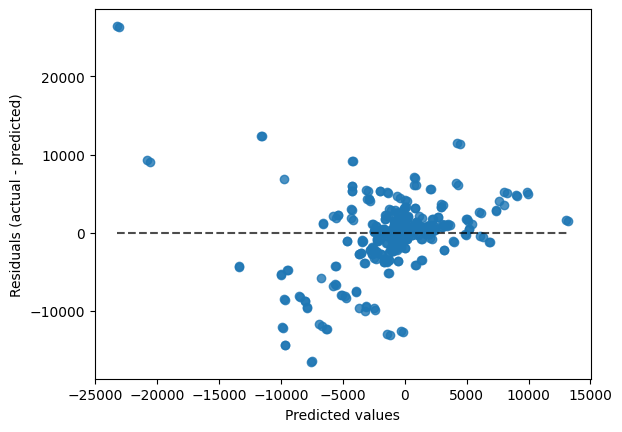

In [45]:
score_RandomForest = test_model(RandomForestRegressor(), X_train, y_train, X_test, y_test)

R^2: 0.5046949693289329
Adjusted R^2: 0.5046949693289329


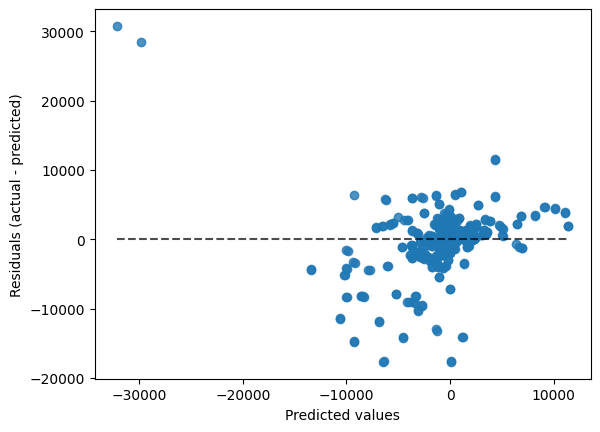

In [46]:
score_ExtraTrees = test_model(ExtraTreesRegressor(), X_train, y_train, X_test, y_test)

R^2: 0.6507275993584143
Adjusted R^2: 0.6507275993584143


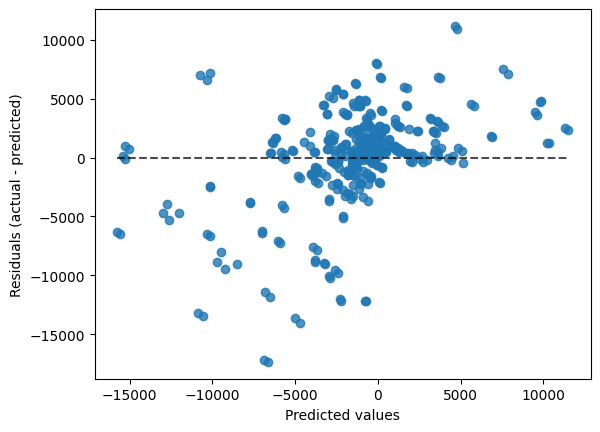

In [47]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
score_poly = test_model(model, X_train, y_train, X_test, y_test)

R^2: 0.3649769637634356
Adjusted R^2: 0.3649769637634356


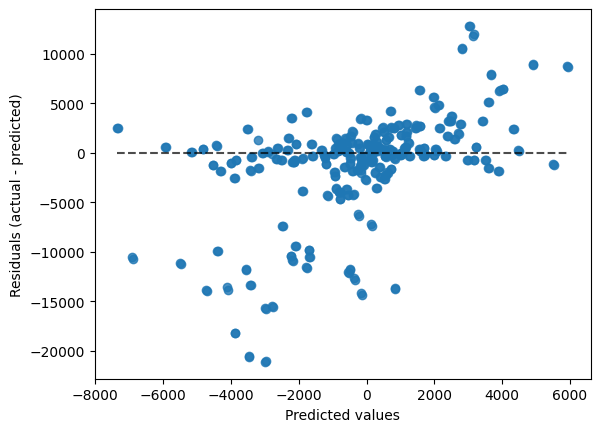

In [48]:
score_linear = test_model(LinearRegression(), X_train, y_train, X_test, y_test)

R^2: 0.46309466690867007
Adjusted R^2: 0.46309466690867007


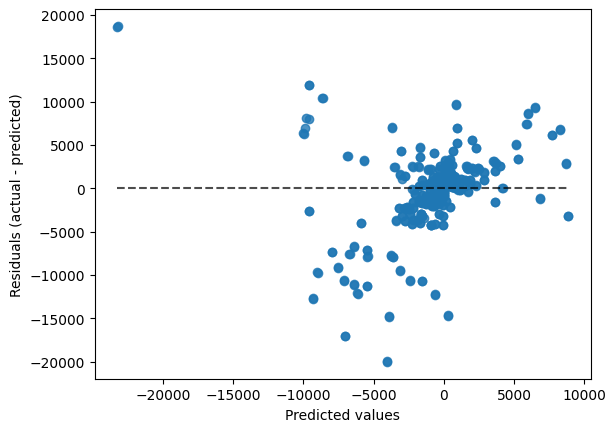

In [49]:
score_KNN = test_model(KNeighborsRegressor(), X_train, y_train, X_test, y_test)

R^2: -0.055856481691364035
Adjusted R^2: -0.055856481691364035


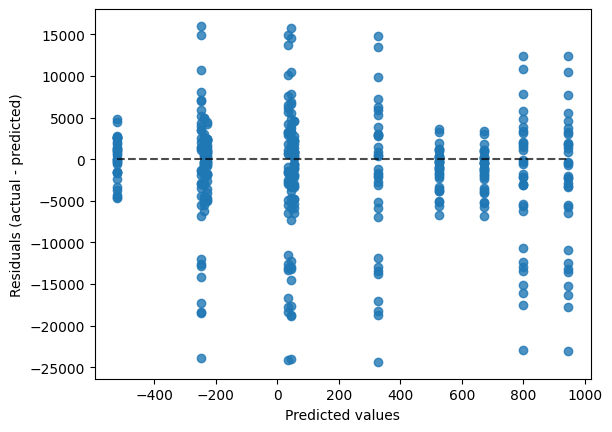

In [50]:
score_SGD = test_model(SGDRegressor(), X_train, y_train, X_test, y_test)

In [51]:
# Loading Swap Rate Model
from pickle import load
with open("../model/swapRateModel.pkl", "rb") as f:
    swapModel = load(f)

In [52]:
def swapModelPredict(model, data, confidence):
    import scipy.stats as stats
    # swapModel prediction is in % unit, need to perform scaling when predcing
    
    # features recreation
    features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2', 'Tenor',  'Swap Rate Std 5']
    X = data
    X = X.rename(columns = {'Swap Rate Lag 1 (Real)': 'Swap Rate Lag 1', 'CMS Tenor': 'Tenor'})
    delay = len(data.loc[data['Value Date'] == "2022-09-02"])
    X['Swap Rate Lag 1'] *= 100 # rescale for model prediction
    X['Swap Rate'] *= 100
    X['Swap Rate Moving Average 2'] = X.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
    X['Swap Rate Std 5'] = X.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
    X_test = X[features]

    # Prediction
    y_test = data['Swap Rate'] 
    y_pred = model.predict(X_test)
    y_pred /= 100 # prediction rescaling to same unit
    
    def confidenceIntervalN(confidence):
        # finding coef and alpha for required confidence
        # confidence = 1 - 2a
        a = (1 - confidence)/2
        coef = stats.norm.ppf(1-a)
        return a, coef
    
    # Constant Variance Prediction Interval
    def swapPredictionInterval():
        # Prediction Interval Using Const variance assumption and Normal Dist assumption of residuals
        a, coef = confidenceIntervalN(confidence)
        y_test = data['Swap Rate'] 
        # residual variance estimator-> MSE
        # Find MSE and convert to standard deviation
        error = sklearn.metrics.mean_squared_error(y_pred, y_test) ** 0.5 
        # CI = [u +- z*sigma]
        upper, lower = y_pred + coef * error, y_pred - coef * error
        return upper, lower
        
    # Validate ideas with with Breach Ratio of Confidence Interval -> BR of less than < 0.01 is good 
    def breachRatio( Upper, Lower, X_test, y_test, confidence):
        # Compare actual_confidence and expected confidence
        # Breach Ratio = Abs(actual - expected)
        # Lower: bound; Upper: bound
        lower_bound = Lower
        upper_bound = Upper
    
        inbound = (y_test >= lower_bound) & (y_test <= upper_bound)
        total_obs = y_test.count()
        total_inbound = inbound.sum() # all true value will be summed
        actual_confidence = total_inbound/total_obs 
        breach_ratio, sign = abs(actual_confidence - confidence), (actual_confidence - confidence) > 0
        return breach_ratio, sign
        
    def printBreachRatio(breach_ratio, sign):
        threshold = 0.01
        if breach_ratio < threshold:
            intervalCondition = "Good"
        else:
            intervalCondition = "overbound" if sign else "underbound"
        print("The breach_ratio of Model is:", breach_ratio, "\nThe prediction interval is", intervalCondition)
    def printWidth(upper, lower):
        width = np.mean(upper-lower)
        print("Average Width of Prediction Interval of Swap Rate is", width, f"(={width*100}%)")
    upper, lower = swapPredictionInterval()
    printWidth(upper, lower)
    breach_ratio, sign = breachRatio(upper, lower, X_test, y_test, confidence)
    printBreachRatio(breach_ratio, sign)
    return y_pred, upper, lower # a pandas DF matching the original DataFrame

In [53]:
alpha = 0.9
y_pred, upper, lower = swapModelPredict(swapModel, data = zero, confidence s= alpha)
upper_name = f'Swap Upper ({alpha*100}% Pred)'
lower_name = f'Swap Lower ({alpha*100}% Pred)'
zero['Swap Rate (Pred)'] = y_pred
zero[upper_name] = upper
zero[lower_name] = lower
zero

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3222198451.py, line 2)

In [ ]:
# Predicted Upper Change = Upper prediction - last swap rate
zero['Swap Rate Change (Upper Pred)'] = zero[upper_name] - zero['Swap Rate Lag 1 (Real)']
zero['Swap Rate Change (Lower Pred)'] = zero[lower_name] - zero['Swap Rate Lag 1 (Real)']
zero

In [ ]:
y_test = zero['Swap Rate']
plt.scatter(y_test, y_pred)
# Calculate R^2 and R^2 adj to evaluate model adequacy
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
#n = X_test.shape[0]
#p = X_test.shape[1]
#adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
#print("Adjusted R^2 =", adjusted_r2)
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

In [ ]:
# The residual plot supported the constant variance residual assumption

In [ ]:
# Notes: First 5 days will have high residual since Std 5 features is not filled

plt.plot(y_test, label = "actual")
#plt.plot(y_pred, label = "prediction")
plt.plot(upper, label = "upper")
plt.plot(lower, label = "lower")
# show the legend
plt.legend()
plt.show()

In [ ]:
# IR model -> given a swap rate change prediction -> output corresponding swap

# Next Step: Find Swap rate Change (upper + lower) * IR model prediction to find predicted TV change (90% Condifence Interval)
# Then validate with 90% Condeidence The value at risk and actual risk (how many the actual TV chagne is in bound of the Value at risk,
# Can calculate tail risk wtih by averaging the outliers value